In [2]:
import os
import shutil
import math

import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
)
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import (
    MulticlassClassificationEvaluator,
    BinaryClassificationEvaluator,
    ClusteringEvaluator
)

from pyspark.mllib.evaluation import BinaryClassificationMetrics


In [3]:
spark = SparkSession.builder \
    .appName("AirlinesDelay-ML-Notebook") \
    .getOrCreate()

sc = spark.sparkContext


25/12/28 01:04:37 WARN Utils: Your hostname, spark resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/12/28 01:04:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/28 01:04:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/28 01:04:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
from pyspark.sql import functions as F

INPUT_CSV = "data/airlines_delay.csv"

df = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv(INPUT_CSV))

df.printSchema()
df.show(5, truncate=False)


root
 |-- Flight: double (nullable = true)
 |-- Time: double (nullable = true)
 |-- Length: double (nullable = true)
 |-- Airline: string (nullable = true)
 |-- AirportFrom: string (nullable = true)
 |-- AirportTo: string (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Class: integer (nullable = true)

+------+------+------+-------+-----------+---------+---------+-----+
|Flight|Time  |Length|Airline|AirportFrom|AirportTo|DayOfWeek|Class|
+------+------+------+-------+-----------+---------+---------+-----+
|2313.0|1296.0|141.0 |DL     |ATL        |HOU      |1        |0    |
|6948.0|360.0 |146.0 |OO     |COS        |ORD      |4        |0    |
|1247.0|1170.0|143.0 |B6     |BOS        |CLT      |3        |0    |
|31.0  |1410.0|344.0 |US     |OGG        |PHX      |6        |0    |
|563.0 |692.0 |98.0  |FL     |BMI        |ATL      |4        |0    |
+------+------+------+-------+-----------+---------+---------+-----+
only showing top 5 rows



In [5]:
df.select("Class").groupBy("Class").count().orderBy("Class").show()

# null var mı?
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show(truncate=False)

+-----+------+
|Class| count|
+-----+------+
|    0|299118|
|    1|240264|
+-----+------+



+------+----+------+-------+-----------+---------+---------+-----+
|Flight|Time|Length|Airline|AirportFrom|AirportTo|DayOfWeek|Class|
+------+----+------+-------+-----------+---------+---------+-----+
|0     |0   |0     |0      |0          |0        |0        |0    |
+------+----+------+-------+-----------+---------+---------+-----+



In [6]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

print("train:", train_df.count())
print("test :", test_df.count())


train: 431452


test : 107930


In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression

label_col = "Class"

cat_cols = ["Airline", "AirportFrom", "AirportTo"]
num_cols = ["Time", "Length", "DayOfWeek"]  # Flight id gibi kolonlar varsa ekleme (gürültü olur)

# Index + OHE
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in cat_cols]
encoder = OneHotEncoder(
    inputCols=[f"{c}_idx" for c in cat_cols],
    outputCols=[f"{c}_ohe" for c in cat_cols],
    handleInvalid="keep"
)

assembler = VectorAssembler(
    inputCols=num_cols + [f"{c}_ohe" for c in cat_cols],
    outputCol="features"
)

lr = LogisticRegression(featuresCol="features", labelCol=label_col, maxIter=50, regParam=0.0)

pipeline_lr = Pipeline(stages=indexers + [encoder, assembler, lr])

model_lr = pipeline_lr.fit(train_df)
pred_lr = model_lr.transform(test_df)

pred_lr.select("features", "Class", "probability", "prediction").show(5, truncate=False)


+-----------------------------------------------------+-----+----------------------------------------+----------+
|features                                             |Class|probability                             |prediction|
+-----------------------------------------------------+-----+----------------------------------------+----------+
|(610,[0,1,2,3,61,349],[420.0,60.0,2.0,1.0,1.0,1.0])  |0    |[0.3395888788122727,0.6604111211877273] |1.0       |
|(610,[0,1,2,3,61,349],[420.0,60.0,3.0,1.0,1.0,1.0])  |1    |[0.3463468441791904,0.6536531558208096] |1.0       |
|(610,[0,1,2,3,61,349],[420.0,60.0,4.0,1.0,1.0,1.0])  |0    |[0.3531673768059933,0.6468326231940067] |1.0       |
|(610,[0,1,2,3,61,349],[420.0,60.0,5.0,1.0,1.0,1.0])  |0    |[0.36004824054148676,0.6399517594585132]|1.0       |
|(610,[0,1,2,18,44,335],[480.0,355.0,3.0,1.0,1.0,1.0])|0    |[0.7174543893144946,0.28254561068550543]|0.0       |
+-----------------------------------------------------+-----+---------------------------

In [8]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

acc_eval = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
f1_eval  = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="f1")
auc_eval = BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol="rawPrediction", metricName="areaUnderROC")

acc = acc_eval.evaluate(pred_lr)
f1  = f1_eval.evaluate(pred_lr)
auc = auc_eval.evaluate(pred_lr)

print("LogReg -> accuracy:", acc)
print("LogReg -> f1      :", f1)
print("LogReg -> AUC     :", auc)

# Confusion matrix
cm = (pred_lr
      .groupBy("Class")
      .pivot("prediction", [0.0, 1.0])
      .count()
      .na.fill(0)
     )
cm.show()


LogReg -> accuracy: 0.645844528861299
LogReg -> f1      : 0.6377829556309456
LogReg -> AUC     : 0.69037677107429


+-----+-----+-----+
|Class|  0.0|  1.0|
+-----+-----+-----+
|    1|24623|23369|
|    0|46337|13601|
+-----+-----+-----+



Manual AUC: 0.6903769700978056


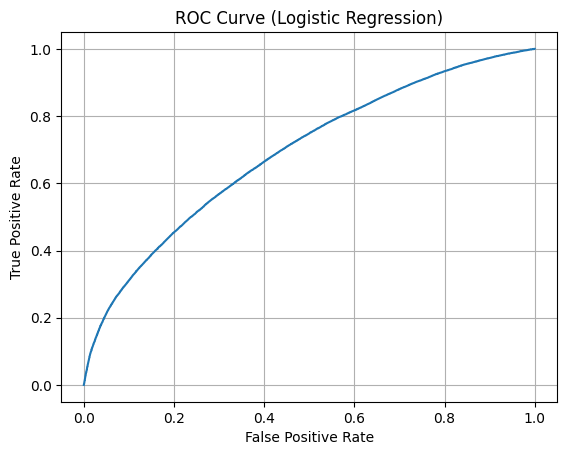

In [11]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1) score = P(Class=1) çıkar
pred_for_roc = pred_lr.select(
    vector_to_array("probability")[1].alias("score"),
    F.col("Class").cast("int").alias("label")
)

# Çok büyükse RAM'i zorlamasın diye sample açabilirsin:
# pred_for_roc = pred_for_roc.sample(False, 0.3, seed=42)

# 2) Driver'a al
pairs = pred_for_roc.rdd.map(lambda r: (float(r["score"]), int(r["label"]))).collect()

# 3) ROC hesapla (manuel, sklearn gerektirmez)
pairs.sort(key=lambda x: -x[0])  # score desc

P = sum(l for _, l in pairs)
N = len(pairs) - P

tp = fp = 0
prev_score = None
roc_points = [(0.0, 0.0)]  # (FPR, TPR)

for score, label in pairs:
    if prev_score is not None and score != prev_score:
        roc_points.append((fp / N if N else 0.0, tp / P if P else 0.0))
    if label == 1:
        tp += 1
    else:
        fp += 1
    prev_score = score

roc_points.append((fp / N if N else 0.0, tp / P if P else 0.0))

fpr = [p[0] for p in roc_points]
tpr = [p[1] for p in roc_points]

# 4) AUC (trapezoid)
auc_manual = 0.0
for i in range(1, len(fpr)):
    auc_manual += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2.0

print("Manual AUC:", auc_manual)

# 5) Plot
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Logistic Regression)")
plt.grid(True)
plt.show()


In [12]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol=label_col, featuresCol="features", maxIter=50, maxDepth=5)

pipeline_gbt = Pipeline(stages=indexers + [encoder, assembler, gbt])
model_gbt = pipeline_gbt.fit(train_df)
pred_gbt = model_gbt.transform(test_df)

acc_gbt = acc_eval.evaluate(pred_gbt)
f1_gbt  = f1_eval.evaluate(pred_gbt)
auc_gbt = auc_eval.evaluate(pred_gbt)

print("GBT -> accuracy:", acc_gbt)
print("GBT -> f1      :", f1_gbt)
print("GBT -> AUC     :", auc_gbt)


25/12/28 01:11:09 WARN MemoryStore: Not enough space to cache rdd_253_0 in memory! (computed 72.3 MiB so far)
25/12/28 01:11:09 WARN BlockManager: Persisting block rdd_253_0 to disk instead.
25/12/28 01:11:10 WARN MemoryStore: Not enough space to cache rdd_253_1 in memory! (computed 258.5 MiB so far)
25/12/28 01:11:10 WARN BlockManager: Persisting block rdd_253_1 to disk instead.
25/12/28 01:11:14 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_255_1 in memory.
25/12/28 01:11:14 WARN MemoryStore: Not enough space to cache rdd_255_1 in memory! (computed 384.0 B so far)
25/12/28 01:11:14 WARN BlockManager: Persisting block rdd_255_1 to disk instead.
25/12/28 01:11:14 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_255_1 in memory.
25/12/28 01:11:14 WARN MemoryStore: Not enough space to cache rdd_255_1 in memory! (computed 384.0 B so far)
25/12/28 01:11:17 WARN MemoryStore: Not enough spa

GBT -> accuracy: 0.6541369406096544
GBT -> f1      : 0.6393314927793113
GBT -> AUC     : 0.7016992668831638


### ML #2 — Route Clustering (KMeans, Unsupervised)

Bu ikinci ML uygulaması: rotaları “gecikme profiline” göre kümeliyoruz.

In [13]:
route_df = (df
    .groupBy("AirportFrom", "AirportTo")
    .agg(
        F.count("*").alias("flight_count"),
        F.avg("Class").alias("delay_rate"),
        F.avg("Length").alias("avg_length"),
        F.avg("Time").alias("avg_time")
    )
    .filter(F.col("flight_count") >= 50)   # az örnekli rotaları ele (istersen 20/100 yap)
)

route_df.show(5, truncate=False)
print("Routes:", route_df.count())


+-----------+---------+------------+-------------------+-----------------+-----------------+
|AirportFrom|AirportTo|flight_count|delay_rate         |avg_length       |avg_time         |
+-----------+---------+------------+-------------------+-----------------+-----------------+
|ROC        |CLE      |77          |0.18181818181818182|70.37662337662337|821.8051948051948|
|PHL        |MCO      |481         |0.42411642411642414|159.2827442827443|745.4781704781705|
|PBI        |DCA      |67          |0.3283582089552239 |134.6417910447761|613.0597014925373|
|MCI        |MKE      |91          |0.6593406593406593 |81.64835164835165|873.0769230769231|
|SMF        |BUR      |222         |0.6036036036036037 |70.0             |820.0675675675676|
+-----------+---------+------------+-------------------+-----------------+-----------------+
only showing top 5 rows



Routes: 3131


k: 2 silhouette: 0.27703189683851803


k: 3 silhouette: 0.29620105863483465


k: 4 silhouette: 0.33918656414980347


k: 5 silhouette: 0.4261397716971


k: 6 silhouette: 0.424806131568121


k: 7 silhouette: 0.4094511261263916


k: 8 silhouette: 0.34315268944828464


k: 9 silhouette: 0.3362579332476672


k: 10 silhouette: 0.3271268076262462


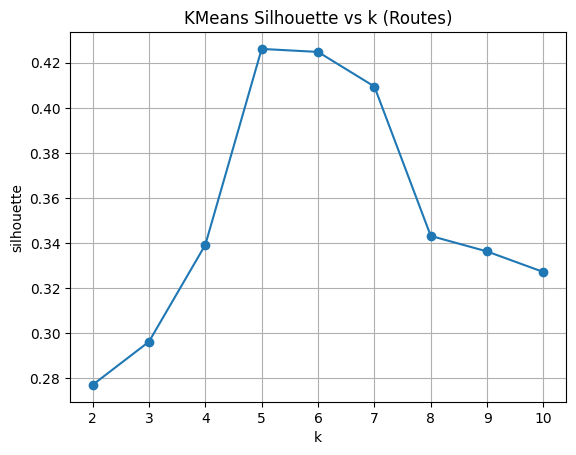

In [14]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

route_assembler = VectorAssembler(
    inputCols=["flight_count", "delay_rate", "avg_length", "avg_time"],
    outputCol="route_features"
)

route_vec = route_assembler.transform(route_df)

scaler = StandardScaler(inputCol="route_features", outputCol="route_features_scaled", withStd=True, withMean=False)
scaler_model = scaler.fit(route_vec)
route_vec = scaler_model.transform(route_vec)

evaluator = ClusteringEvaluator(featuresCol="route_features_scaled", metricName="silhouette", distanceMeasure="squaredEuclidean")

ks = list(range(2, 11))
sil_scores = []

for k in ks:
    km = KMeans(k=k, seed=42, featuresCol="route_features_scaled")
    m = km.fit(route_vec)
    p = m.transform(route_vec)
    s = evaluator.evaluate(p)
    sil_scores.append(s)
    print("k:", k, "silhouette:", s)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(ks, sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.title("KMeans Silhouette vs k (Routes)")
plt.grid(True)
plt.show()


In [15]:
best_k = ks[sil_scores.index(max(sil_scores))]
print("Best k:", best_k)

kmeans = KMeans(k=best_k, seed=42, featuresCol="route_features_scaled")
kmeans_model = kmeans.fit(route_vec)
route_clustered = kmeans_model.transform(route_vec)

route_clustered.select("AirportFrom", "AirportTo", "flight_count", "delay_rate", "avg_length", "avg_time", "prediction") \
               .orderBy(F.desc("delay_rate")) \
               .show(20, truncate=False)

# Küme özetleri (raporda çok iyi durur)
cluster_summary = (route_clustered
    .groupBy("prediction")
    .agg(
        F.count("*").alias("num_routes"),
        F.avg("delay_rate").alias("avg_delay_rate"),
        F.avg("flight_count").alias("avg_flight_count"),
        F.avg("avg_length").alias("avg_length"),
        F.avg("avg_time").alias("avg_time"),
    )
    .orderBy("prediction")
)

cluster_summary.show(truncate=False)


Best k: 5


+-----------+---------+------------+------------------+------------------+-----------------+----------+
|AirportFrom|AirportTo|flight_count|delay_rate        |avg_length        |avg_time         |prediction|
+-----------+---------+------------+------------------+------------------+-----------------+----------+
|LAS        |PIT      |61          |0.9508196721311475|254.50819672131146|776.4754098360655|3         |
|LAS        |TPA      |62          |0.9354838709677419|251.1290322580645 |793.7096774193549|3         |
|MDW        |SLC      |62          |0.9354838709677419|215.0             |706.8548387096774|3         |
|MDW        |SEA      |62          |0.9032258064516129|284.03225806451616|831.7741935483871|4         |
|STL        |TPA      |70          |0.9               |136.0             |834.2857142857143|3         |
|LAX        |HOU      |118         |0.8898305084745762|184.4915254237288 |870.6779661016949|3         |
|MDW        |ABQ      |62          |0.8870967741935484|192.5    

+----------+----------+-------------------+------------------+------------------+-----------------+
|prediction|num_routes|avg_delay_rate     |avg_flight_count  |avg_length        |avg_time         |
+----------+----------+-------------------+------------------+------------------+-----------------+
|0         |840       |0.3915668652702338 |126.24285714285715|101.88840453685019|897.4375560393984|
|1         |295       |0.43149311232604387|475.1966101694915 |122.5987422832095 |804.8174028580096|
|2         |1012      |0.33889100306309045|126.82608695652173|119.0475611562008 |708.4217514822342|
|3         |606       |0.6667446226025385 |136.97359735973598|117.17392871511029|806.0092490302605|
|4         |378       |0.511478938034226  |139.95767195767195|274.7325665584365 |817.933431063254 |
+----------+----------+-------------------+------------------+------------------+-----------------+

